**ตรวจสอบ GPU (CUDA) พร้อมใช้งาน**

In [ ]:
import torch

# ตรวจสอบว่ามี GPU พร้อมใช้งานหรือไม่
if torch.cuda.is_available():
    print("✅ CUDA is AVAILABLE!")
    print(f"Name of GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("❌ CUDA is NOT available. Please check Colab Runtime settings (Runtime -> Change runtime type -> Hardware accelerator: GPU).")

✅ CUDA is AVAILABLE!
Name of GPU: Tesla T4
Number of GPUs: 1


In [ ]:
# --- 2. ตั้งค่า MLflow Tracking ---
mlflow.set_tracking_uri("http://ec2-34-224-66-205.compute-1.amazonaws.com:5000")
mlflow.set_experiment("Pill_KD_MobileNetV2")


In [ ]:
!pip install mlflow torch torchvision scikit-learn optuna boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
from google.colab import drive

# 1.1 เชื่อมต่อ Google Drive (ยืนยันว่าเชื่อมต่อสำเร็จ)
drive.mount('/content/drive')

# 1.2 กำหนด Path ของไฟล์ ZIP และ Path ปลายทาง
zip_path = '/content/drive/MyDrive/dataset/pills_dataset_resnet.zip'
extract_dir = '/content/pill_dataset/'

# สร้างโฟลเดอร์ปลายทาง
os.makedirs(extract_dir, exist_ok=True)

print(f"กำลังพยายามแตกไฟล์จาก: {zip_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
กำลังพยายามแตกไฟล์จาก: /content/drive/MyDrive/dataset/pills_dataset_resnet.zip
ไฟล์ ZIP ถูกเปิดสำเร็จ กำลังแตกไฟล์...
✅ แตกไฟล์เสร็จสมบูรณ์แล้ว!

ตัวอย่างโฟลเดอร์ที่ถูกแตกออกมา (5 รายการแรก):
['pills_dataset_resnet', '__MACOSX']


**ทำ EDA เพื่อวิเคราะห์ DATASET**

กำลังค้นหารูปภาพใน: /content/pill_dataset/pills_dataset_resnet
--------------------------------------------------
✅ จำนวนรูปภาพทั้งหมดที่พบ: 9786
✅ จำนวนเม็ดยาที่ไม่ซ้ำกัน (Classes): 46
--------------------------------------------------
                                                path   pill_id
0  /content/pill_dataset/pills_dataset_resnet/tra...  Vesicare
1  /content/pill_dataset/pills_dataset_resnet/tra...  Vesicare
2  /content/pill_dataset/pills_dataset_resnet/tra...  Vesicare
3  /content/pill_dataset/pills_dataset_resnet/tra...  Vesicare
4  /content/pill_dataset/pills_dataset_resnet/tra...  Vesicare

💊 การกระจายตัวของเม็ดยา 5 อันดับแรกและอันดับสุดท้าย:
pill_id
Nifedipine      240
Biopress        236
Wecoli          235
Diovan          229
Famotidinefc    229
Name: count, dtype: int64
...
pill_id
Amaryl      193
Vistaril    190
Minlife     187
Allegra     186
Kascoal     182
Name: count, dtype: int64

💡 Min/Max Samples ต่อ Class: 182 / 240


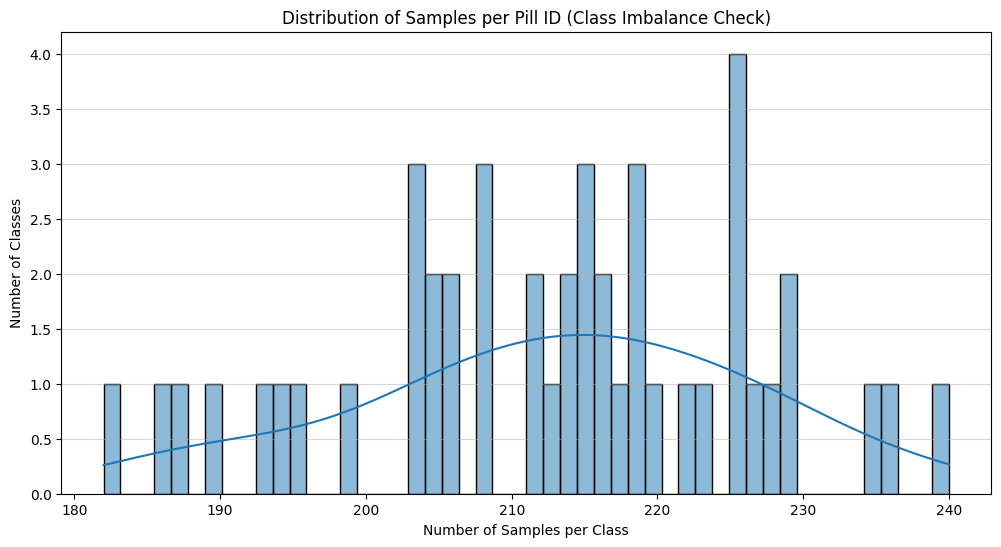


🖼️ สถิติขนาดภาพ (จากตัวอย่าง 2000 ภาพ):
        width  height
count  2000.0  2000.0
mean    650.0   650.0
std       0.0     0.0
min     650.0   650.0
25%     650.0   650.0
50%     650.0   650.0
75%     650.0   650.0
max     650.0   650.0

💡 ขนาดภาพที่พบบ่อยที่สุด: (650, 650)


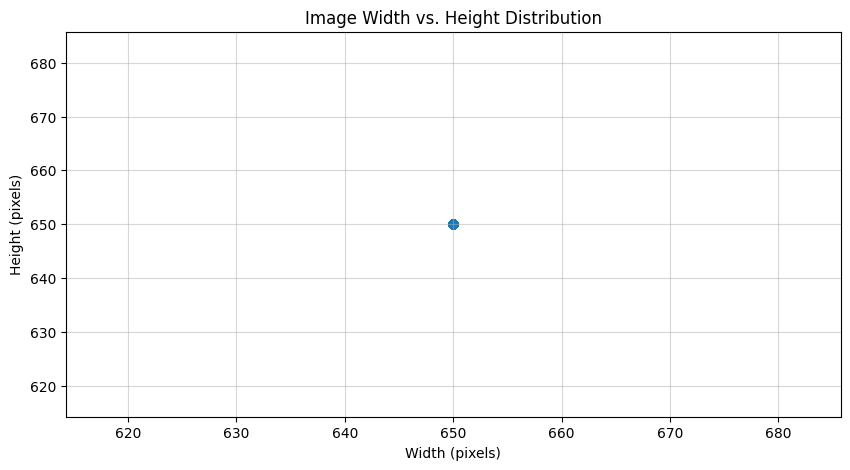

--------------------------------------------------


In [ ]:
import os
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Path ที่ถูกต้อง
data_dir_final = '/content/pill_dataset/pills_dataset_resnet'

print(f"กำลังค้นหารูปภาพใน: {data_dir_final}")

# 1. ค้นหารูปภาพทั้งหมดและสร้าง DataFrame
image_paths = glob(os.path.join(data_dir_final, '**', '*.jpg'), recursive=True)
data = pd.DataFrame({'path': image_paths})
data['pill_id'] = data['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))
data = data[data['pill_id'] != '']

print("-" * 50)
print(f"✅ จำนวนรูปภาพทั้งหมดที่พบ: {len(data)}")
print(f"✅ จำนวนเม็ดยาที่ไม่ซ้ำกัน (Classes): {data['pill_id'].nunique()}")
print("-" * 50)
print(data.head())


# --- 2. EDA: Class Distribution (การกระจายตัวของ Classes) ---
class_counts = data['pill_id'].value_counts()

print("\n💊 การกระจายตัวของเม็ดยา 5 อันดับแรกและอันดับสุดท้าย:")
print(class_counts.head())
print('...')
print(class_counts.tail())

min_count = class_counts.min()
max_count = class_counts.max()
print(f"\n💡 Min/Max Samples ต่อ Class: {min_count} / {max_count}")

# พล็อตการกระจายตัว (คุณจะเห็นภาพกราฟใน Colab)
plt.figure(figsize=(12, 6))
sns.histplot(class_counts, kde=True, bins=50)
plt.title('Distribution of Samples per Pill ID (Class Imbalance Check)')
plt.xlabel('Number of Samples per Class')
plt.ylabel('Number of Classes')
plt.grid(axis='y', alpha=0.5)
plt.show() # ใช้ show() ใน Colab


# --- 3. EDA: Image Resolution (ขนาดภาพ) ---
def get_image_size(path):
    try:
        with Image.open(path) as img:
            return img.size # (width, height)
    except Exception:
        return None

# สุ่มตัวอย่างรูปภาพ 2000 ภาพ เพื่อความเร็ว
sample_data = data.sample(min(2000, len(data)), random_state=42)
sample_data['size'] = sample_data['path'].apply(get_image_size)
sample_data = sample_data.dropna(subset=['size'])

if not sample_data.empty:
    sample_data[['width', 'height']] = pd.DataFrame(sample_data['size'].tolist(), index=sample_data.index)

    print(f"\n🖼️ สถิติขนาดภาพ (จากตัวอย่าง {len(sample_data)} ภาพ):")
    print(sample_data[['width', 'height']].describe())

    mode_size = sample_data['size'].mode()
    if not mode_size.empty:
        print(f"\n💡 ขนาดภาพที่พบบ่อยที่สุด: {mode_size.iloc[0]}")

    # พล็อต Scatter Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(sample_data['width'], sample_data['height'], alpha=0.5)
    plt.title('Image Width vs. Height Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.grid(axis='both', alpha=0.5)
    plt.show() # ใช้ show() ใน Colab

print("-" * 50)

In [ ]:
# --- Cell 3: Data Preparation ---
import zipfile

# 1. Unzip Dataset (ถ้ายังไม่ได้แตกไฟล์)
zip_path = '/content/drive/MyDrive/dataset/pills_dataset_resnet.zip'
extract_dir = '/content/pill_dataset/'
data_dir_final = os.path.join(extract_dir, 'pills_dataset_resnet')

if not os.path.exists(data_dir_final):
    print(f"📂 กำลังแตกไฟล์จาก: {zip_path}")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Unzip เสร็จสิ้น")
else:
    print("✅ พบไฟล์ข้อมูลแล้ว ข้ามการ Unzip")

# 2. ค้นหารูปภาพและสร้าง DataFrame
image_paths = glob(os.path.join(data_dir_final, '**', '*.jpg'), recursive=True)
data = pd.DataFrame({'filepath': image_paths})
data['pill_id'] = data['filepath'].apply(lambda x: os.path.basename(os.path.dirname(x)))
data = data[data['pill_id'] != ''] # กรองรูปที่ไม่อยู่ในโฟลเดอร์คลาส

# 3. สร้าง Mapping Label
unique_pills = sorted(data['pill_id'].unique())
pill_to_label = {pill_id: i for i, pill_id in enumerate(unique_pills)}
data['label'] = data['pill_id'].map(pill_to_label)
NUM_CLASSES = len(unique_pills)

print(f"💊 จำนวนคลาสทั้งหมด: {NUM_CLASSES}")
print(f"🖼️ จำนวนรูปภาพทั้งหมด: {len(data)}")

# 4. Custom Dataset Class
class PillDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        label = self.df.iloc[idx]['label']
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return dummy tensor or handle error appropriately
            return torch.zeros((3, 224, 224)), label

# 5. Defines Transforms (Resize เป็น 224x224 สำคัญมาก!)
NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    NORMALIZE
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    NORMALIZE
])

# 6. Split Data
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# 7. Create DataLoaders
# (Batch Size เอาไปกำหนดใน Optuna หรือ Fix ไว้ที่นี่ก็ได้ ถ้า GPU ไหว 64 กำลังดี)
BATCH_SIZE = 64
train_loader = DataLoader(PillDataset(train_df, train_transforms), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(PillDataset(val_df, val_transforms), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders พร้อมใช้งาน")

✅ พบไฟล์ข้อมูลแล้ว ข้ามการ Unzip
💊 จำนวนคลาสทั้งหมด: 46
🖼️ จำนวนรูปภาพทั้งหมด: 9786
✅ DataLoaders พร้อมใช้งาน


In [ ]:
# --- Cell 4: Models & Helper Functions ---

# 1. ฟังก์ชันสร้าง Teacher (ต้อง Load Weights ที่ดีที่สุดถ้ามี หรือใช้ Default ImageNet)
def get_teacher(num_classes, device):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.to(device)
    model.eval() # Teacher ต้องเป็น Eval mode เสมอ
    return model

# 2. ฟังก์ชันสร้าง Student (MobileNetV2) - จะถูกเรียกใหม่ทุก Trial
def get_student(num_classes, device):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    model.to(device)
    return model

# 3. KD Loss Function
def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    soft_targets = nn.functional.softmax(teacher_logits / T, dim=1)
    soft_prob = nn.functional.log_softmax(student_logits / T, dim=1)
    loss_soft = nn.KLDivLoss(reduction='batchmean')(soft_prob, soft_targets) * (T * T)
    loss_hard = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * loss_soft + (1. - alpha) * loss_hard

# 4. Training Loop (สำหรับ 1 Epoch)
def train_one_epoch(teacher, student, loader, optimizer, device, T, alpha):
    student.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = teacher(inputs)

        student_logits = student(inputs)
        loss = distillation_loss(student_logits, teacher_logits, labels, T, alpha)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# 5. Validation Loop
def validate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print("✅ Functions พร้อมใช้งาน")

✅ Functions พร้อมใช้งาน


In [ ]:
# --- Cell 4.5: Train Teacher First! ---
print("👨‍🏫 Teacher are learning ...")

# 1. สร้าง Teacher Model
teacher_model = get_teacher(NUM_CLASSES, device)
teacher_model.train() # เปิดโหมดฝึกฝน (Unfreeze)

# 2. Config สำหรับ Teacher
# Teacher ใช้ Learning Rate ต่ำๆ หน่อยเพราะฉลาดอยู่แล้ว แค่ปรับตัวนิดหน่อย
criterion_teacher = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=1e-4)
EPOCHS_TEACHER = 6

# 3. Loop เทรน Teacher (แบบปกติ ไม่ใช่ Distillation)
for epoch in range(EPOCHS_TEACHER):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_teacher.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion_teacher(outputs, labels)
        loss.backward()
        optimizer_teacher.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validate Teacher
    val_acc = validate(teacher_model, val_loader, device)

    print(f"👨‍🏫 Teacher Epoch {epoch+1}/{EPOCHS_TEACHER} | Loss: {running_loss/len(train_dataset):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# 4. Save Teacher ที่เก่งแล้วเก็บไว้ (เผื่อใช้ซ้ำ)
torch.save(teacher_model.state_dict(), "trained_teacher_resnet50.pth")
print("✅ Teacher Learn Successfully")

👨‍🏫 กำลังส่ง Teacher (ResNet-50) ไปเรียนเรื่องยา...
👨‍🏫 Teacher Epoch 1/10 | Loss: 1.1750 | Train Acc: 80.88% | Val Acc: 98.16%
👨‍🏫 Teacher Epoch 2/10 | Loss: 0.1049 | Train Acc: 96.91% | Val Acc: 99.80%
👨‍🏫 Teacher Epoch 3/10 | Loss: 0.0185 | Train Acc: 99.59% | Val Acc: 100.00%
👨‍🏫 Teacher Epoch 4/10 | Loss: 0.0205 | Train Acc: 99.37% | Val Acc: 99.74%
👨‍🏫 Teacher Epoch 5/10 | Loss: 0.0077 | Train Acc: 99.80% | Val Acc: 99.69%
👨‍🏫 Teacher Epoch 6/10 | Loss: 0.0114 | Train Acc: 99.71% | Val Acc: 99.59%
👨‍🏫 Teacher Epoch 7/10 | Loss: 0.0006 | Train Acc: 99.99% | Val Acc: 100.00%
👨‍🏫 Teacher Epoch 8/10 | Loss: 0.0000 | Train Acc: 100.00% | Val Acc: 100.00%
👨‍🏫 Teacher Epoch 9/10 | Loss: 0.0000 | Train Acc: 100.00% | Val Acc: 100.00%
👨‍🏫 Teacher Epoch 10/10 | Loss: 0.0000 | Train Acc: 100.00% | Val Acc: 100.00%
✅ Teacher เรียนจบแล้ว! พร้อมไปสอนน้องต่อได้เลย


In [ ]:
# --- Cell 5: Optuna Objective (Corrected) ---

# 1. โหลด Teacher (โครงสร้างเปล่า)
teacher_model = models.resnet50(weights=None)
num_ftrs = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# ⚠️ สำคัญ: ต้องโหลดสมองที่เพิ่งเทรนเสร็จ (จาก Cell 4.5) เข้าไป
try:
    teacher_model.load_state_dict(torch.load("trained_teacher_resnet50.pth"))
    print("✅ Loaded 'trained_teacher_resnet50.pth' successfully.")
except FileNotFoundError:
    print("❌ ไม่พบไฟล์โมเดล Teacher! กรุณารัน Cell 4.5 เพื่อเทรน Teacher ก่อน")
    # (ถ้าไม่มีไฟล์ อาจจะยอมให้รันต่อไม่ได้ เพราะ Teacher จะมั่ว)

teacher_model.to(device)
teacher_model.eval() # ล็อกสมองอาจารย์

def objective(trial):
    # 2. สุ่ม Hyperparameters (ช่วงการค้นหา)
    trial_T = trial.suggest_float("temperature", 2.0, 8.0)     # ลองช่วง 2-8
    trial_alpha = trial.suggest_float("alpha", 0.2, 0.8)       # ลองช่วง 0.2-0.8
    trial_lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # 3. สร้าง Student ใหม่ (MobileNetV2)
    student_model = get_student(NUM_CLASSES, device)

    # 4. Optimizer
    optimizer = optim.Adam(student_model.parameters(), lr=trial_lr)

    # 5. Start MLflow Nested Run
    # nested=True จะทำให้ Trial นี้ไปอยู่ใต้ Run ใหญ่ (Parent Run) ใน Cell 6
    with mlflow.start_run(run_name=f"Trial_{trial.number}", nested=True):
        # Log Params: เพื่อให้ Compare ได้ว่าค่าไหนดี
        mlflow.log_params({
            "T": trial_T,
            "alpha": trial_alpha,
            "lr": trial_lr,
            "student_arch": "MobileNetV2"
        })

        best_acc = 0.0
        EPOCHS_PER_TRIAL = 5 # จำนวนรอบสั้นๆ เพื่อคัดกรอง

        for epoch in range(EPOCHS_PER_TRIAL):
            # Train & Validate
            train_loss = train_one_epoch(teacher_model, student_model, train_loader, optimizer, device, trial_T, trial_alpha)
            val_acc = validate(student_model, val_loader, device)

            # Log Metrics: เพื่อดู Learning Curve ใน MLflow
            mlflow.log_metrics({"train_loss": train_loss, "val_acc": val_acc}, step=epoch)

            # แจ้ง Optuna (เพื่อ Pruning)
            trial.report(val_acc, epoch)

            if val_acc > best_acc:
                best_acc = val_acc

            # Pruning: ถ้าผลแย่กว่าค่าเฉลี่ย ตัดจบเลย ประหยัดเวลา
            if trial.should_prune():
                mlflow.set_tag("status", "pruned")
                raise optuna.exceptions.TrialPruned()

        # Log Final Metric: ค่านี้สำคัญที่สุดในการ Sort หาตัวเทพ
        mlflow.log_metric("final_val_acc", best_acc)

        return best_acc

✅ Loaded 'trained_teacher_resnet50.pth' successfully.


In [ ]:
# --- Cell 6: Run Optuna (with Parent Run) ---

# สร้าง Run ใหญ่ครอบไว้ เพื่อรวมทุก Trial ไว้ในกลุ่มเดียวกัน
with mlflow.start_run(run_name="Optuna_Optimization_Batch1"):
    print("🚀 Starting Optimization...")

    study = optuna.create_study(direction="maximize", study_name="KD_Pills")
    study.optimize(objective, n_trials=5) # ลองรัน 10 รอบ

    print(f"🏆 Best Params: {study.best_params}")

    # Log Best Params ไว้ที่ Parent Run ด้วย จะได้หาง่ายๆ
    mlflow.log_params(study.best_params)

[I 2025-11-17 08:19:05,085] A new study created in memory with name: KD_Pills


🚀 Starting Optimization...


[I 2025-11-17 08:24:56,541] Trial 0 finished with value: 99.94892747701736 and parameters: {'temperature': 2.379693292816474, 'alpha': 0.6329996431275198, 'learning_rate': 0.0008418541153777096}. Best is trial 0 with value: 99.94892747701736.


🏃 View run Trial_0 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/6b4c639f12aa4a6c9e10dc1a729ba39a
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:30:44,094] Trial 1 finished with value: 100.0 and parameters: {'temperature': 5.971135416355251, 'alpha': 0.2078451089181085, 'learning_rate': 0.0003682779964048965}. Best is trial 1 with value: 100.0.


🏃 View run Trial_1 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/1240aa57ff55443fa7cedaeb1b2cba6c
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:36:33,089] Trial 2 finished with value: 100.0 and parameters: {'temperature': 6.5218339566416015, 'alpha': 0.347813817164245, 'learning_rate': 0.004686138717505478}. Best is trial 1 with value: 100.0.


🏃 View run Trial_2 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/d931359ae5284bd1a4371d61cfea90bc
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:42:23,333] Trial 3 finished with value: 100.0 and parameters: {'temperature': 5.061564051434118, 'alpha': 0.6162035777099968, 'learning_rate': 0.0006280956947739708}. Best is trial 1 with value: 100.0.


🏃 View run Trial_3 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/66724794a720432ca906d8c7ecb8563e
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:48:11,233] Trial 4 finished with value: 99.94892747701736 and parameters: {'temperature': 5.538242417460275, 'alpha': 0.7078616814617349, 'learning_rate': 0.00019887424499055346}. Best is trial 1 with value: 100.0.


🏃 View run Trial_4 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/022700b15386449ca569cf4ebc077d5e
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:49:21,147] Trial 5 pruned. 


🏃 View run Trial_5 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/e700bb6957bf4fdebbc9765d5d8b8779
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:55:07,469] Trial 6 finished with value: 100.0 and parameters: {'temperature': 3.977521792942346, 'alpha': 0.3418792913711134, 'learning_rate': 0.0007007171332975027}. Best is trial 1 with value: 100.0.


🏃 View run Trial_6 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/d7a597b81850489e921ec1d97f2ee8e2
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:57:26,832] Trial 7 pruned. 


🏃 View run Trial_7 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/8ec0248083eb4774a0fed16b6d6d43c2
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:58:36,401] Trial 8 pruned. 


🏃 View run Trial_8 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/ac84fc4d376a4535b176637588d27011
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


[I 2025-11-17 08:59:46,064] Trial 9 pruned. 


🏃 View run Trial_9 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/ca5aae21ad734b658bcf848f55e339ae
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757
🏆 Best Params: {'temperature': 5.971135416355251, 'alpha': 0.2078451089181085, 'learning_rate': 0.0003682779964048965}
🏃 View run Optuna_Optimization_Batch1 at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757/runs/644a81d5c1814b93a1345d2ba1d5edd3
🧪 View experiment at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/experiments/129765318694917757


In [ ]:
import os

# --- AWS Credentials Setup ---
# ใส่ Key ของคุณแทนที่ '...'
os.environ["AWS_ACCESS_KEY_ID"] = "AKIAxxxxxxxxxxxxxxxx"
os.environ["AWS_SECRET_ACCESS_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_DEFAULT_REGION"] = "ap-southeast-1"

In [ ]:
# --- Cell 7: Train Final Student Model (with Early Stopping) ---
import copy

print("🏆 Real Student Train")

# 1. ดึงค่า Hyperparameters ที่ดีที่สุดจาก Optuna
best_params = study.best_params
print(f"⚙️ best Parameter use : {best_params}")

# 2. สร้าง Student ใหม่ (สมองโล่งๆ)
final_student = get_student(NUM_CLASSES, device)

# 3. ตั้งค่าตามสูตรเทพ
optimizer_final = optim.Adam(final_student.parameters(), lr=best_params["learning_rate"])
best_T = best_params["temperature"]
best_alpha = best_params["alpha"]

# --- Early Stopping Class ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_acc, model):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f"   ⏳ EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation accuracy increase.'''
        print(f"   🔥 New High Score! ({val_acc:.2f}%) Saving model...")
        self.best_model_state = copy.deepcopy(model.state_dict())

# 4. เริ่ม MLflow Run
with mlflow.start_run(run_name="Final_Production_Model"):
    # Log Params
    mlflow.log_params(best_params)
    mlflow.log_param("student_arch", "MobileNetV2")

    EPOCHS_FINAL = 30 #
    mlflow.log_param("max_epochs", EPOCHS_FINAL)

    # Initialize Early Stopping (Patience=5 คือถ้าไม่เก่งขึ้น 5 รอบติดกัน ให้หยุด)
    early_stopper = EarlyStopping(patience=5, min_delta=0.01)

    for epoch in range(EPOCHS_FINAL):
        print(f"\nEpoch {epoch+1}/{EPOCHS_FINAL}")

        # Train
        train_loss = train_one_epoch(teacher_model, final_student, train_loader, optimizer_final, device, best_T, best_alpha)

        # Validate
        val_acc = validate(final_student, val_loader, device)

        print(f"   Loss: {train_loss:.4f} | Acc: {val_acc:.2f}%")

        # Log Metrics to MLflow
        mlflow.log_metrics({"train_loss": train_loss, "val_acc": val_acc}, step=epoch)

        # Check Early Stopping
        early_stopper(val_acc, final_student)

        if early_stopper.early_stop:
            print("🛑 Early stopping triggered! (หยุดก่อนจะ Overfit)")
            break

    # 5. โหลด Weight ที่ดีที่สุดกลับมา (ไม่ใช่ Weight ของรอบสุดท้าย)
    print("\n💾 Loading best model weights...")
    final_student.load_state_dict(early_stopper.best_model_state)

    # 6. Save to Disk & Log Artifact to MLflow
    model_filename = "best_student_model.pth"
    torch.save(final_student.state_dict(), model_filename)

    # Log Artifact (ไฟล์โมเดล) ขึ้น Server
    mlflow.log_artifact(model_filename)

    # (Optional) Log Model as PyTorch Flavor (เพื่อให้ Deploy ง่ายขึ้นในอนาคต)
    # mlflow.pytorch.log_model(final_student, "model")

    print(f"✅ บันทึกไฟล์ '{model_filename}' ลง MLflow เรียบร้อย!")
    print(f"🏆 Final Best Accuracy: {early_stopper.best_score:.2f}%")

print("\n👉 ขั้นตอนต่อไป: ไปที่ notebook 'quantization_and_tflite.ipynb' เพื่อแปลงไฟล์นี้เป็น TFLite")

🏆 Real Student Train
⚙️ best Parameter use : {'temperature': 5.971135416355251, 'alpha': 0.2078451089181085, 'learning_rate': 0.0003682779964048965}

Epoch 1/30
   Loss: 5.4006 | Acc: 99.85%
   🔥 New High Score! (99.85%) Saving model...

Epoch 2/30
   Loss: 0.3961 | Acc: 99.90%
   🔥 New High Score! (99.90%) Saving model...

Epoch 3/30
   Loss: 0.2087 | Acc: 100.00%
   🔥 New High Score! (100.00%) Saving model...

Epoch 4/30
   Loss: 0.1252 | Acc: 100.00%
   ⏳ EarlyStopping counter: 1 out of 5

Epoch 5/30
   Loss: 0.1737 | Acc: 98.42%
   ⏳ EarlyStopping counter: 2 out of 5

Epoch 6/30
   Loss: 0.1419 | Acc: 100.00%
   ⏳ EarlyStopping counter: 3 out of 5

Epoch 7/30
   Loss: 0.1045 | Acc: 100.00%
   ⏳ EarlyStopping counter: 4 out of 5

Epoch 8/30
   Loss: 0.0930 | Acc: 99.95%
   ⏳ EarlyStopping counter: 5 out of 5
🛑 Early stopping triggered! (หยุดก่อนจะ Overfit)

💾 Loading best model weights...
🏃 View run Final_Production_Model at: http://ec2-34-224-66-205.compute-1.amazonaws.com:5000/#/e

NoCredentialsError: Unable to locate credentials